In [1]:
# -*- coding: utf-8 -*-

import meep as mp
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50                 # pixels/um

dpml = 1.0                      # PML thickness
sz = 10 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4                   # min wavelength
wvl_max = 0.8                   # max wavelength
fmin = 1/wvl_max                # min frequency
fmax = 1/wvl_min                # max frequency
fcen = 0.5*(fmin+fmax)          # center frequency
df = fmax-fmin                  # frequency width
nfreq = 50                      # number of frequency bins

def planar_reflectance(theta):    
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(theta)

    # plane of incidence is XZ; rotate counter clockwise (CCW) about y-axis
    k = mp.Vector3(z=fmin).rotate(mp.Vector3(y=1), theta_r)
    
    # if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3
    
    sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, center=mp.Vector3(z=-0.5*sz+dpml))]

    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        dimensions=dimensions,
                        resolution=resolution)

    refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25*sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=-0.5*sz+dpml), 1e-9))

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)

    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,0.5*sz), center=mp.Vector3(z=0.25*sz), material=mp.Medium(index=3.5))]

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        dimensions=dimensions,
                        resolution=resolution)

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=-0.5*sz+dpml), 1e-9))

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    wvls = np.empty(nfreq)
    theta_out = np.empty(nfreq)
    R = np.empty(nfreq)
    for i in range(nfreq):
        wvls[i] = 1/freqs[i]
        theta_out[i] = math.degrees(math.asin(k.x/freqs[i]))
        R[i] = -refl_flux[i]/empty_flux[i]
        print("refl:, {}, {}, {}, {}".format(k.x,wvls[i],theta_out[i],R[i]))
        
    return k.x*np.ones(nfreq), wvls, theta_out, R 

In [2]:
theta_in = np.arange(0,85,5)
wvl = np.empty(nfreq)
kxs = np.empty((nfreq,theta_in.size))
thetas = np.empty((nfreq,theta_in.size))
Rmeep = np.empty((nfreq,theta_in.size))

for j in range(theta_in.size):
  kxs[:,j], wvl, thetas[:,j], Rmeep[:,j] = planar_reflectance(theta_in[j])

# create a 2d matrix for the wavelength by repeating the column vector for each angle
wvls = np.transpose(np.matlib.repmat(wvl,theta_in.size,1))

-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.25332329653323415 / 0.25332329653323415 = 1.0
field decay(t = 100.01): 6.806395978139867e-16 / 0.25332329653323415 = 2.6868417043700194e-15
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.25332329652480207 / 0.25332329652480207 = 1.0
field decay(t = 100.01): 1.9736380723733672e-11 / 0.25332329652480207 = 7.790985272371642e-11
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.0, 0.8, 0.0, 0.29476330384323207
refl:, 0.0, 0.784, 0.0, 0.29416578611798405
refl:, 0.0, 0.7686274509803922, 0.0, 0.2935560666132851
refl:, 0.0, 0.7538461538461539, 0.0, 0.29293290546540196
refl:, 0.0, 0.739622641509434, 0.0, 0.2922951429790378
refl:, 0.0, 0.7259259259259259, 0.0, 0.29164324229177097
refl:, 0.0, 0.7127272727272727, 0.0, 0.29097731021514417
refl:, 0.0, 0.7, 0.0, 0.29029575759541565
refl:, 0.0, 0.6877192982456141, 

field decay(t = 50.01): 0.24974540044608928 / 0.24974540044608928 = 1.0
field decay(t = 100.01): 2.1519308385946042e-11 / 0.24974540044608928 = 8.61649838095467e-11
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.2170602220836629, 0.8, 10.0, 0.2893781746253207
refl:, 0.2170602220836629, 0.784, 9.798006528153513, 0.288998732433702
refl:, 0.2170602220836629, 0.7686274509803922, 9.604050171837292, 0.2885938951899122
refl:, 0.2170602220836629, 0.7538461538461539, 9.417658416993296, 0.28816419107846264
refl:, 0.2170602220836629, 0.739622641509434, 9.238395240840497, 0.28770900366948954
refl:, 0.2170602220836629, 0.7259259259259259, 9.06585764090149, 0.28722834374816003
refl:, 0.2170602220836629, 0.7127272727272727, 8.899672554443574, 0.2867235913729682
refl:, 0.2170602220836629, 0.7, 8.739494117841588, 0.28619525258422535
refl:, 0.2170602220836629, 0.6877192982456141, 8.585001222725978, 0.28564218452120266
refl:, 0.2170602220836629, 0.6758620689655173, 8.435895331947279, 0.285064789

field decay(t = 50.01): 0.23946072431081186 / 0.23946072431081186 = 1.0
field decay(t = 100.01): 2.143367304660103e-13 / 0.23946072431081186 = 8.950809410724429e-13
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.23946072470582727 / 0.23946072470582727 = 1.0
field decay(t = 100.01): 2.2924410648414684e-11 / 0.23946072470582727 = 9.573348897434795e-11
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.4275251791570859, 0.8, 20.0, 0.27287026974445927
refl:, 0.4275251791570859, 0.784, 19.583468236198428, 0.2732024101218738
refl:, 0.4275251791570859, 0.7686274509803922, 19.184283570762837, 0.2734622444200681
refl:, 0.4275251791570859, 0.7538461538461539, 18.80136282780684, 0.27365329059595683
refl:, 0.4275251791570859, 0.739622641509434, 18.433712921276232, 0.27378076185161915
refl:, 0.4275251791570859, 0.7259259259259259, 18.080421505473552, 0.27384851240423785
refl:, 0.4275251791570859, 0.7127

field decay(t = 50.01): 0.22375100718842 / 0.22375100718842 = 1.0
field decay(t = 100.01): 4.4054832270861915e-13 / 0.22375100718842 = 1.9689221883038714e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.22375100783149995 / 0.22375100783149995 = 1.0
field decay(t = 100.01): 2.604590852088861e-11 / 0.22375100783149995 = 1.1640577074183724e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.6249999999999999, 0.8, 29.999999999999993, 0.2442050337697129
refl:, 0.6249999999999999, 0.784, 29.34058157502373, 0.24592026654412946
refl:, 0.6249999999999999, 0.7686274509803922, 28.711017527148794, 0.2474593095717218
refl:, 0.6249999999999999, 0.7538461538461539, 28.10922128260952, 0.24883736533494075
refl:, 0.6249999999999999, 0.739622641509434, 27.53330580109674, 0.25006920079221073
refl:, 0.6249999999999999, 0.7259259259259259, 26.98155921981659, 0.25116546178265714
refl:, 0.6249999999999999, 0.

field decay(t = 50.01): 0.20454876789491885 / 0.20454876789491885 = 1.0
field decay(t = 100.01): 7.178635175771892e-13 / 0.20454876789491885 = 3.509498125874663e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.20454876813558592 / 0.20454876813558592 = 1.0
field decay(t = 100.01): 2.8174572450318613e-11 / 0.20454876813558592 = 1.3774012284270024e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.8034845121081741, 0.8, 39.99999999999999, 0.20179462162966672
refl:, 0.8034845121081741, 0.784, 39.04509528455022, 0.2059250719323383
refl:, 0.8034845121081741, 0.7686274509803922, 38.139646206191365, 0.20966397204966036
refl:, 0.8034845121081741, 0.7538461538461539, 37.27949726994566, 0.21305427397378518
refl:, 0.8034845121081741, 0.739622641509434, 36.46098976062103, 0.21613269723029083
refl:, 0.8034845121081741, 0.7259259259259259, 35.680884053707004, 0.21892741270212848
refl:, 0.80348451210

field decay(t = 50.01): 0.18417632037527257 / 0.18417632037527257 = 1.0
field decay(t = 100.01): 1.0178427595748204e-12 / 0.18417632037527257 = 5.5264583280895835e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.18417631975521828 / 0.18417631975521828 = 1.0
field decay(t = 100.01): 2.8713012611847576e-11 / 0.18417631975521828 = 1.5589958931750262e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.9575555538987225, 0.8, 50.0, 0.14429067301668
refl:, 0.9575555538987225, 0.784, 48.6530933185261, 0.15241249489296654
refl:, 0.9575555538987225, 0.7686274509803922, 47.39207738436693, 0.15970237410745958
refl:, 0.9575555538987225, 0.7538461538461539, 46.207396358038395, 0.16628917742963503
refl:, 0.9575555538987225, 0.739622641509434, 45.091066324150106, 0.1722363131532337
refl:, 0.9575555538987225, 0.7259259259259259, 44.036334278275795, 0.1776288135399773
refl:, 0.9575555538987225, 0.712727

field decay(t = 50.01): 0.16505586379118362 / 0.16505586379118362 = 1.0
field decay(t = 100.01): 1.6796657955389861e-12 / 0.16505586379118362 = 1.0176347310289891e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.16505586311279807 / 0.16505586311279807 = 1.0
field decay(t = 100.01): 3.3223715038456985e-11 / 0.16505586311279807 = 2.0128769988468766e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 1.0825317547305482, 0.8, 59.99999999999999, 0.07360773441443474
refl:, 1.0825317547305482, 0.784, 58.07108488083593, 0.08756183349395384
refl:, 1.0825317547305482, 0.7686274509803922, 56.311309260669624, 0.09993186958234106
refl:, 1.0825317547305482, 0.7538461538461539, 54.69254540505164, 0.11102792920544496
refl:, 1.0825317547305482, 0.739622641509434, 53.19365179333026, 0.12095671757064261
refl:, 1.0825317547305482, 0.7259259259259259, 51.798237196004614, 0.12989111490169047
refl:, 1.08253175

field decay(t = 50.01): 0.14944315649486126 / 0.14944315649486126 = 1.0
field decay(t = 100.01): 4.987937476864823e-12 / 0.14944315649486126 = 3.3376820952228335e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.14944315644072245 / 0.14944315644072245 = 1.0
field decay(t = 100.01): 3.807851695141726e-11 / 0.14944315644072245 = 2.548026812222836e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 1.1746157759823854, 0.8, 70.0, 0.008715934286147569
refl:, 1.1746157759823854, 0.784, 67.05783140972835, 0.024210799209089452
refl:, 1.1746157759823854, 0.7686274509803922, 64.53417775149677, 0.04029873111181387
refl:, 1.1746157759823854, 0.7538461538461539, 62.31059707934406, 0.0555678814867085
refl:, 1.1746157759823854, 0.739622641509434, 60.31629899672389, 0.06970125775811391
refl:, 1.1746157759823854, 0.7259259259259259, 58.50481213939229, 0.08255524971343331
refl:, 1.1746157759823854, 0.71272

field decay(t = 50.01): 0.1392134275610875 / 0.1392134275610875 = 1.0
field decay(t = 100.01): 1.3144200424788948e-11 / 0.1392134275610875 = 9.441761944278838e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
Meep: using complex fields.
field decay(t = 50.01): 0.13921342793500532 / 0.13921342793500532 = 1.0
field decay(t = 100.01): 9.871965144118156e-11 / 0.13921342793500532 = 7.091244925544889e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 1.23100969126526, 0.8, 79.99999999999994, 0.028667884842985224
refl:, 1.23100969126526, 0.784, 74.82079670263325, 0.0021347453734021486
refl:, 1.23100969126526, 0.7686274509803922, 71.11813585396203, 0.0041164349187047915
refl:, 1.23100969126526, 0.7538461538461539, 68.12392493650243, 0.017504855468406976
refl:, 1.23100969126526, 0.739622641509434, 65.57213417097068, 0.03282494395652445
refl:, 1.23100969126526, 0.7259259259259259, 63.331955818023665, 0.04792423816150501
refl:, 1.23100969126526, 0.712

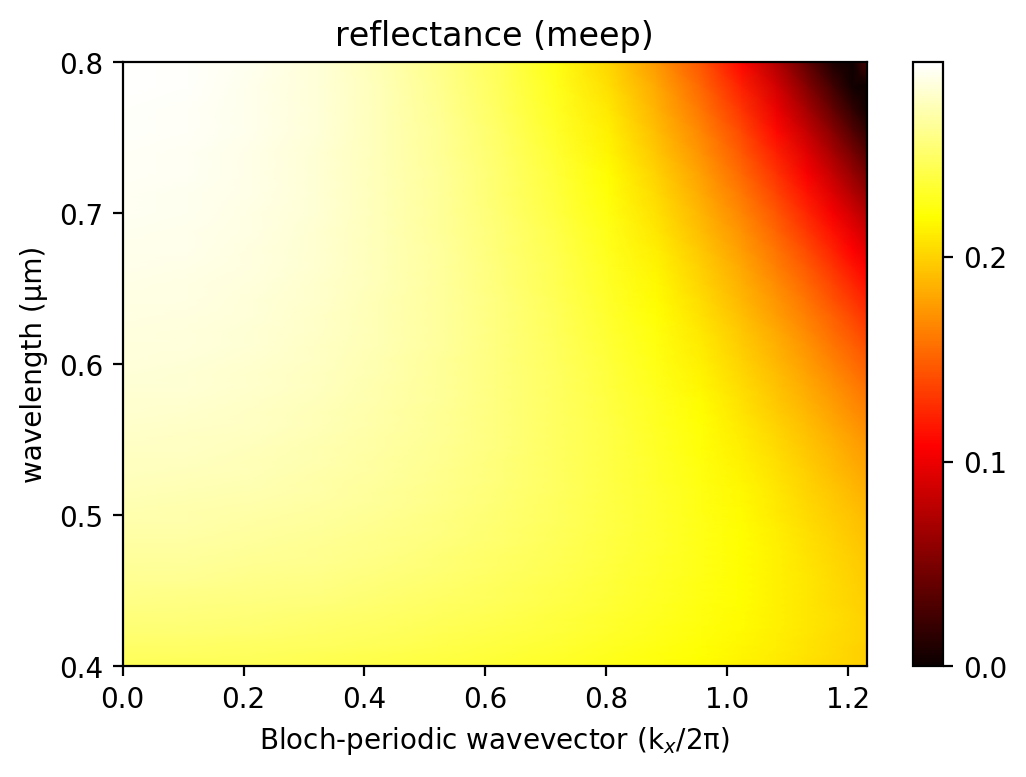

In [9]:
plt.figure(dpi=200)
plt.pcolormesh(kxs, wvls, Rmeep, cmap='hot', shading='gouraud', vmin=0, vmax=Rmeep.max())
plt.axis([kxs[0,0], kxs[0,-1], wvl_min, wvl_max])
plt.yticks([t for t in np.linspace(0.4,0.8,5)])
plt.xlabel(r"Bloch-periodic wavevector (k$_x$/2π)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0,0.4,5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0,0.4,5)])

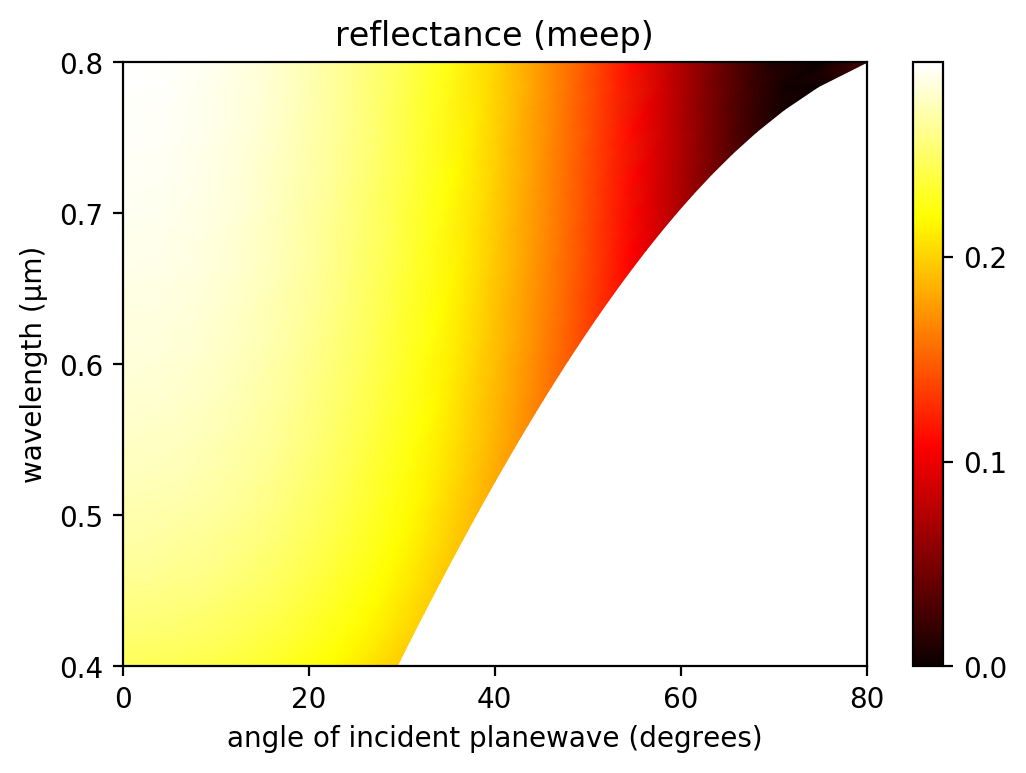

In [10]:
plt.figure(dpi=200)
plt.pcolormesh(thetas, wvls, Rmeep, cmap='hot', shading='gouraud', vmin=0, vmax=Rmeep.max())
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xticks([t for t in range(0,100,20)])
plt.yticks([t for t in np.linspace(0.4,0.8,5)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0,0.4,5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0,0.4,5)])

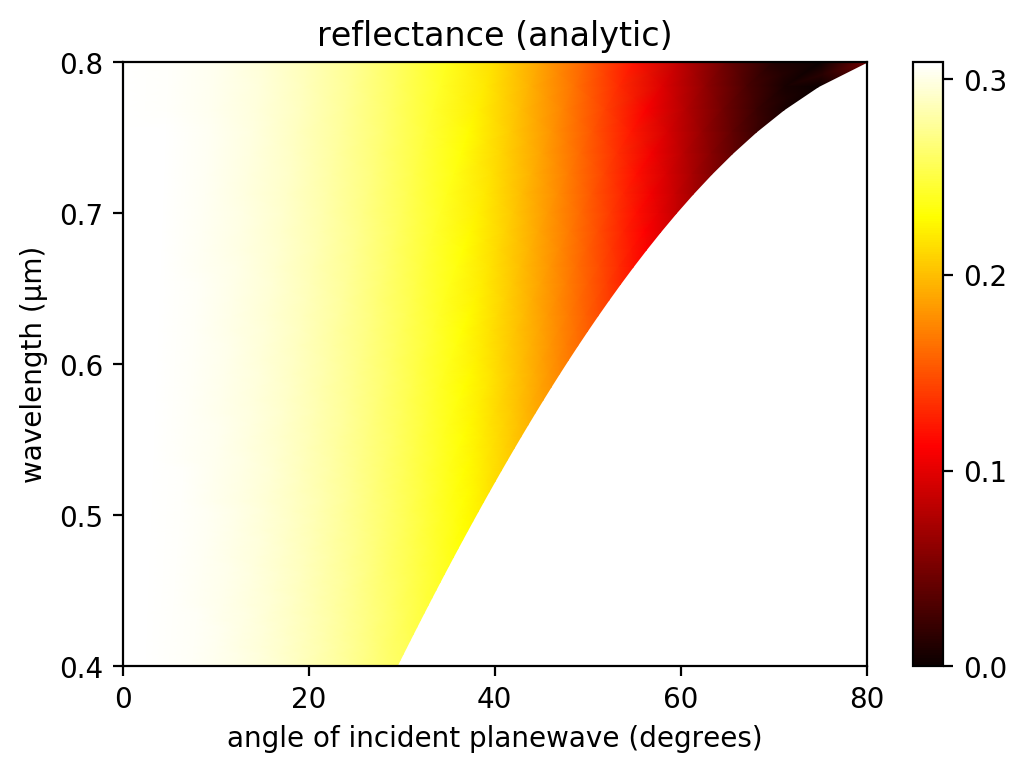

In [11]:
n1=1
n2=3.5

# compute angle of refracted planewave in medium n2
# for incident planewave in medium n1 at angle theta_in
theta_out = lambda theta_in: math.asin(n1*math.sin(theta_in)/n2)

# compute Fresnel reflectance for P-polarization in medium n2
# for incident planewave in medium n1 at angle theta_in
Rfresnel = lambda theta_in: math.fabs((n1*math.cos(theta_out(theta_in))-n2*math.cos(theta_in))/(n1*math.cos(theta_out(theta_in))+n2*math.cos(theta_in)))**2

Ranalytic = np.empty((nfreq, theta_in.size))
for m in range(wvl.size):
    for n in range(theta_in.size):
        Ranalytic[m,n] = Rfresnel(math.radians(thetas[m,n]))

plt.figure(dpi=200)
plt.pcolormesh(thetas, wvls, Ranalytic, cmap='hot', shading='gouraud', vmin=0, vmax=Ranalytic.max())
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xticks([t for t in range(0,100,20)])
plt.yticks([t for t in np.linspace(0.4,0.8,5)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (analytic)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0,0.4,5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0,0.4,5)])